In [1]:
import warnings
warnings.filterwarnings("ignore") 
from IPython.core.display import display, HTML

import time

import numpy as np
from numpy import matlib

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
import scipy

Explorando dados

(5000, 2)


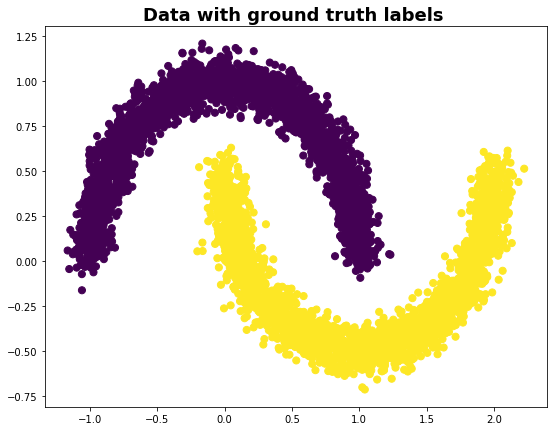

In [2]:
random_state = 21
X_mn, y_mn = make_moons(5000, noise=.07, random_state=random_state)
print(X_mn.shape)
cmap = 'viridis'
dot_size=50

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data with ground truth labels ', fontsize=18, fontweight='demi')

ax.scatter(X_mn[:, 0], X_mn[:, 1],c=y_mn,s=dot_size, cmap=cmap)

## Passo 1
### Hybrid Representative Selection

In [3]:
def getRepresentivesByRandomSelection(data, pSize):
    N = data.shape[0]
    if pSize > N:
        pSize = N
    
    selectIdx = np.random.permutation(np.arange(N))[:pSize]
    randSelect = []
    for i in selectIdx:
        randSelect.append(data[i,:])

    return np.array(randSelect)

def getRepresentativesByHybridSelection(data, pSize, cntTimes=10):
    N = data.shape[0]
    bigPSize = cntTimes * pSize
    
    if pSize > N: 
        pSize = N
    if bigPSize > N: 
        bigPSize = N

    #random selection
    np.random.seed(int(time.time()))
    RpBigPdata = getRepresentivesByRandomSelection(data, bigPSize)
    
    #KNN selection
    RpData = KMeans(n_clusters=pSize, max_iter=cntTimes).fit(RpBigPdata)
    
    return RpData

RpData = getRepresentativesByHybridSelection(X_mn, 1000, 300)

In [4]:
RpData.cluster_centers_

array([[ 1.93245879,  0.46403458],
       [ 0.14734761,  0.2578482 ],
       [-0.48290698,  0.83477871],
       ...,
       [ 1.0764473 , -0.44177175],
       [-0.76188338,  0.51442493],
       [ 1.95612408,  0.09796099]])

## Passo 2
### Approximation of K-Nearest Representatives

In [5]:
cntRepCls = int(np.floor(np.sqrt(RpData.cluster_centers_.shape[0])))
print(cntRepCls)
AprData = KMeans(n_clusters=cntRepCls, max_iter=600).fit(RpData.cluster_centers_)

31


In [6]:
AprData.labels_.shape

(1000,)

In [7]:
AprData.cluster_centers_

array([[ 1.38438727e-01, -2.52944325e-02],
       [ 1.71737275e+00, -1.88796912e-01],
       [-7.81719595e-01,  4.80142159e-01],
       [ 5.93388874e-01,  8.05006792e-01],
       [ 7.33703508e-01, -4.51373169e-01],
       [-3.22968177e-01,  9.45326099e-01],
       [ 9.54499145e-01,  2.49419273e-01],
       [-9.96192654e-01,  6.09457533e-02],
       [ 2.02731798e+00,  4.55961109e-01],
       [ 1.41638360e-01,  9.78499387e-01],
       [ 1.34577277e+00, -4.66432006e-01],
       [ 1.57543890e-03,  4.22987830e-01],
       [-7.13523483e-01,  7.00516739e-01],
       [ 7.49667485e-01,  5.06971632e-01],
       [ 1.87614537e+00, -2.37084544e-02],
       [-9.41821355e-01,  3.03268937e-01],
       [ 1.15593425e+00, -4.41716759e-01],
       [ 2.29036245e-01, -2.22048834e-01],
       [ 9.69364341e-01, -5.19304530e-01],
       [ 1.96094321e+00,  2.27252069e-01],
       [-8.85639857e-02,  1.02486076e+00],
       [ 1.53474859e+00, -3.37432950e-01],
       [ 1.01671806e+00,  4.82392362e-02],
       [ 3.

In [8]:
N = X_mn.shape[0]
p = AprData.cluster_centers_.shape[0]

centerDist = np.zeros((N, p))
for i in range(centerDist.shape[0]):
    for j in range(centerDist.shape[1]):
        centerDist[i,j] = np.linalg.norm(X_mn[i]-AprData.cluster_centers_[j])

In [9]:
minCenterIdxs = np.argmin(centerDist, axis=1)
cntRepCls = AprData.cluster_centers_.shape[0]
# minCenterIdxs
minCenterIdxs.shape

(5000,)

In [10]:
nearestRepInRpFeaIdx = np.zeros((N), dtype=np.int32)
for i in range(p):
    originalIdxs = np.where(minCenterIdxs == i)[0]
    aprDataIdxs = np.where(AprData.labels_ == i)[0]

    originalTemp = np.take(X_mn, originalIdxs).ravel()
    aprDataTemp = np.take(RpData.cluster_centers_, aprDataIdxs).ravel()

    temp = np.zeros((originalTemp.shape[0], aprDataTemp.shape[0]))

    for j in range(temp.shape[0]):
        for k in range(temp.shape[1]):
            temp[j, k] = np.linalg.norm(originalTemp[j]-aprDataTemp[k])

    tempMin = np.argmin(temp, axis=1)

    for j in range(temp.shape[0]):
        nearestRepInRpFeaIdx[originalIdxs[j]] = int(aprDataIdxs[tempMin[j]])

In [11]:
Knn = 5
neighSize = 10*Knn
RpFeaW = np.zeros((RpData.cluster_centers_.shape[0],RpData.cluster_centers_.shape[0]))

for j in range(RpFeaW.shape[0]):
        for k in range(RpFeaW.shape[1]):
            RpFeaW[j, k] = np.linalg.norm(RpData.cluster_centers_[j]-RpData.cluster_centers_[k])

RpFeaKnnIdx = np.argsort(RpFeaW, axis=1, kind='mergesort')

RpFeaKnnIdx = RpFeaKnnIdx[:,:int(neighSize)]
RpFeaKnnDist = np.zeros((N,RpFeaKnnIdx.shape[1]));

#print(RpFeaKnnDist.shape)
#print(nearestRepInRpFeaIdx.shape)
for i in range(RpData.cluster_centers_.shape[0]):
    
    originalIdxs = np.where(nearestRepInRpFeaIdx == i)[0]
    originalTemp = np.take(X_mn, originalIdxs).ravel()
    #print(originalIdxs)
    #RpFea(RpFeaKnnIdx(i,:),:)
    RpFeatTemp = np.take(RpData.cluster_centers_, RpFeaKnnIdx[i]).ravel()
    
    temp = np.ones((originalTemp.shape[0], RpFeatTemp.shape[0]))

    for j in range(temp.shape[0]):
        for k in range(temp.shape[1]):
            temp[j, k] = np.linalg.norm(originalTemp[j]-RpFeatTemp[k])
    
    for j in range(temp.shape[0]):
        RpFeaKnnDist[originalIdxs[j], :] = temp[j]

RpFeaKnnDist

array([[0.00227086, 0.54495093, 0.70372229, ..., 0.03836246, 1.34189099,
        0.05236845],
       [0.05372887, 0.18919574, 0.30031478, ..., 2.10703647, 0.1139436 ,
        0.78919755],
       [0.01450607, 0.37480598, 1.31012324, ..., 1.53469887, 0.89273168,
        1.08663471],
       ...,
       [0.02698227, 0.77930558, 0.47791287, ..., 0.78081319, 0.90368186,
        1.52185931],
       [0.07413834, 0.90819776, 0.59104716, ..., 0.91350699, 1.96224146,
        1.70865594],
       [0.01633148, 1.36178104, 0.21316165, ..., 0.15188907, 0.74977085,
        0.45541921]])

In [12]:
RpFeaKnnIdxFull = RpFeaKnnIdx[nearestRepInRpFeaIdx,:];
print(RpFeaKnnIdxFull.shape)

(5000, 50)


In [13]:
knnDist = np.zeros((N,Knn));
knnIdx = np.zeros((N,Knn));

for i in range(Knn):
    idx = np.argmin(RpFeaKnnDist, axis=1)
    minV = np.amin(RpFeaKnnDist, axis=1)
    temp = ((idx)*N) + np.arange(N).T
    
    knnDist [:, i] = minV
    
    for j in range(len(temp)):
        
        knnIdx[j, i] = RpFeaKnnIdxFull[j, i]
        
        if(temp[j] < N):
            RpFeaKnnDist[j, i] = np.inf
            
print(RpFeaKnnDist)

[[       inf 0.54495093 0.70372229 ... 0.03836246 1.34189099 0.05236845]
 [       inf 0.18919574 0.30031478 ... 2.10703647 0.1139436  0.78919755]
 [       inf 0.37480598 1.31012324 ... 1.53469887 0.89273168 1.08663471]
 ...
 [       inf 0.77930558 0.47791287 ... 0.78081319 0.90368186 1.52185931]
 [       inf 0.90819776 0.59104716 ... 0.91350699 1.96224146 1.70865594]
 [       inf 1.36178104 0.21316165 ... 0.15188907 0.74977085 0.45541921]]


In [14]:
knnMeanDiff = np.mean(knnDist)
Gsdx = np.exp(-(np.power(knnDist,2))/2*np.power(knnMeanDiff,2))
print(Gsdx)

[[1.         0.99999992 0.99999992 0.99999992 0.99999992]
 [0.99999741 0.99999632 0.99999632 0.99999632 0.99999632]
 [0.99999981 0.9999998  0.9999998  0.9999998  0.9999998 ]
 ...
 [0.99999935 0.9999985  0.9999985  0.9999985  0.9999985 ]
 [0.99999507 0.99999448 0.99999448 0.99999448 0.99999448]
 [0.99999976 0.99999617 0.99999617 0.99999617 0.99999617]]


In [15]:
Gsdx[Gsdx == 0] = np.finfo(float).eps

In [16]:
Gidx = matlib.repmat(np.arange(N), Knn, 1).T
Gidx

array([[   0,    0,    0,    0,    0],
       [   1,    1,    1,    1,    1],
       [   2,    2,    2,    2,    2],
       ...,
       [4997, 4997, 4997, 4997, 4997],
       [4998, 4998, 4998, 4998, 4998],
       [4999, 4999, 4999, 4999, 4999]])

In [17]:
def sparse(i, j, v, m, n):
    """
    Create and compressing a matrix that have many zeros
    Parameters:
        i: 1-D array representing the index 1 values 
            Size n1
        j: 1-D array representing the index 2 values 
            Size n1
        v: 1-D array representing the values 
            Size n1
        m: integer representing x size of the matrix >= n1
        n: integer representing y size of the matrix >= n1
    Returns:
        s: 2-D array
            Matrix full of zeros excepting values v at indexes i, j
    """
    return scipy.sparse.csr_matrix((v, (i, j)), shape=(m, n))

In [18]:
p = RpData.cluster_centers_.shape[0]

B = sparse(Gidx.ravel(), knnIdx.ravel(), Gsdx.ravel(), N, p).toarray()


## Passo 3
### Bipartite Graph Partitioning

In [19]:
B

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
dx = np.sum(B, 1)
dx = np.where(dx == 0, 1e-10, dx)
dx = 1/dx
Dx = np.zeros((N, N))
np.fill_diagonal(Dx, dx)
Er = B.T @ Dx @ B

In [21]:
d = np.sum(Er.real, 1);
d = 1/np.sqrt(d)
D = np.zeros((p, p))
np.fill_diagonal(D, d)
Dr = D @ Er @ D
where_are_NaNs = np.isnan(Dr)
Dr[where_are_NaNs] = 0
Dr = (Dr + Dr.T)/2

In [22]:
aval, avec = np.linalg.eig(Dr)

In [23]:
Nsec = 2
idx = np.argsort(aval, kind='mergesort')[::-1]
Ncut_avec = D @ avec[:,idx[:Nsec]]
where_are_NaNs = np.isnan(Ncut_avec)
Ncut_avec[where_are_NaNs] = 0

In [24]:
res = Dx @ B @ Ncut_avec

In [25]:
res.shape

(5000, 2)

In [26]:
norm = (np.sqrt(np.sum(res*res,1)) + 1e-10)
for i in range(res.shape[0]):
    res[i,:] = res[i,:]/norm[i]

In [27]:
res

array([[-4.37187686e-03, -9.99990432e-01],
       [-9.99999989e-01,  6.05517317e-15],
       [-4.37187686e-03, -9.99990432e-01],
       ...,
       [-9.99999989e-01, -7.79585949e-15],
       [-9.99999989e-01,  6.47475030e-15],
       [-9.99999989e-01, -5.27154022e-15]])

In [28]:
K =  KMeans(n_clusters=2, max_iter=1000).fit(res)

In [29]:
pred = K.labels_

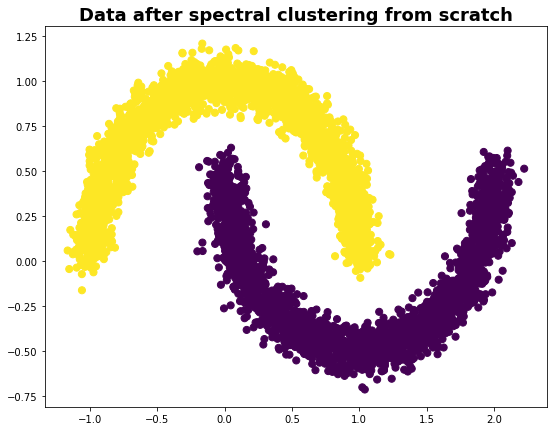

In [30]:
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data after spectral clustering from scratch', fontsize=18, fontweight='demi')
ax.scatter(X_mn[:, 0], X_mn[:, 1],c=pred,s=dot_size, cmap=cmap)